In [7]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from params import doubling_time

GPT5_LAUNCH_DATE = datetime(2025, 8, 7)
O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print("Loaded libraries")

Loaded libraries


In [10]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at 2.28hr on {O3_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()


# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)


quarters = []
# Start with Q3 2025 since GPT5 launched in August
for year in range(2025, 2030):
    start_q = 3 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)

print(
    f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}"
)
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - GPT5_LAUNCH_DATE).days

    if days_from_gpt5 < 0:
        continue

    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        doublings = days_from_gpt5 / tau_samples[i]
        task_lengths[i] = 2.28 * (2**doublings)

    task_lengths = np.minimum(task_lengths, 2000)

    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)

    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")

    print(
        f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_gpt5:>4}"
    )

    results.append(
        {
            "quarter": f"{year}Q{q}",
            "date": quarter_date,
            "mean": mean_val,
            "median": median_val,
            "p5": p5,
            "p95": p95,
            "days": days_from_gpt5,
            "task_lengths": task_lengths,
        }
    )

    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [
    (2, "2 hours"),
    (4, "4 hours"),
    (8, "1 day"),
    (16, "2 days"),
    (24, "3 days"),
    (40, "1 week"),
    (174, "1 month"),
]

for hours, name in milestones:
    for r in results:
        if r["median"] >= hours:
            prob = np.mean(r["task_lengths"] >= hours) * 100
            date_str = r["date"].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: GPT5 at 2.28hr on 2025-04-16

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q3       2025-09-30   2.7hr      2.7hr      [2.1hr - 3.1hr]             54
2025Q4       2025-12-31   4.2hr      3.7hr      [2.8hr - 5.4hr]            146

2026Q1       2026-03-31   6.4hr      5.2hr      [3.8hr - 1.1d]             236
2026Q2       2026-06-30   1.3d       7.3hr      [5.0hr - 1.9d]             327
2026Q3       2026-09-30   2.1d       1.3d       [6.6hr - 3.3d]             419
2026Q4       2026-12-31   3.4d       1.8d       [1.1d - 1.2wk]             511

2027Q1       2027-03-31   1.1wk      2.5d       [1.4d - 2.0wk]             601
2027Q2       2027-06-30   1.8wk      3.5d       [1.8d - 3.6wk]             692
2027Q3       2027-09-30   2.9wk      5.0d       [2.2d - 6.5wk]             784
2027Q4       2027-12-3

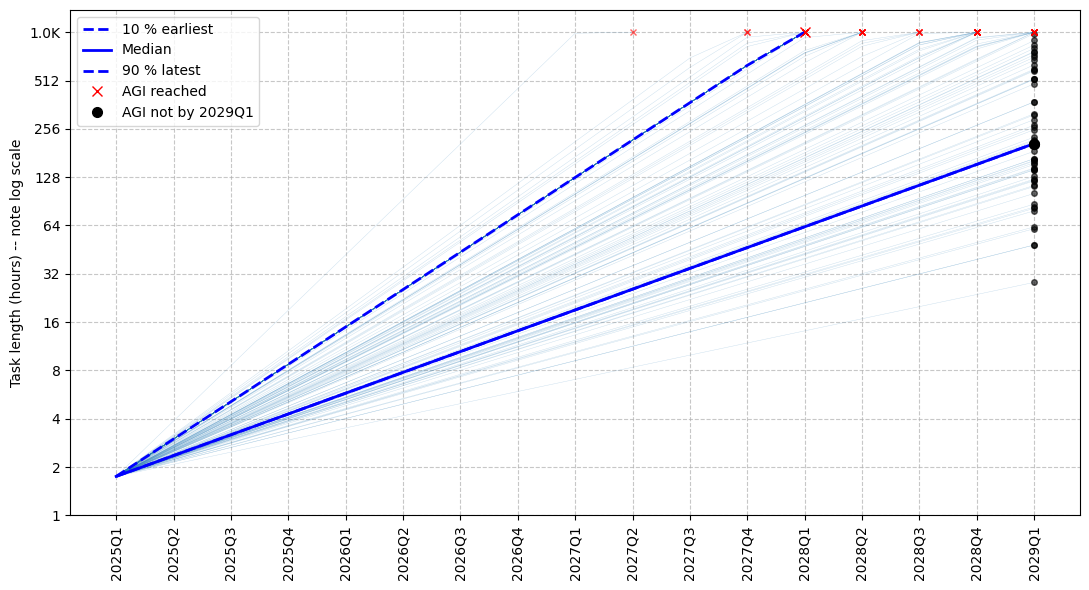

In [11]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=1.75,
    agi_task_length=100_000,
    shift=0,
    n_quarters=16,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [12]:
print("PREDICT CLAUDE 4")

claude_4_launch_date = datetime(2025, 5, 22)
days_since_o3 = (claude_4_launch_date - O3_LAUNCH_DATE).days


def model():
    doublings = days_since_o3 / doubling_time
    return 1.75 * (2**doublings)


print("Model predictions for Claude 4")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(
    f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})"
)
print("Actual observed: Claude 4 Opus at ~1.1-1.3 hours")

PREDICT CLAUDE 4
Model predictions for Claude 4
Predicted: 2.0hr (1.9hr - 2.2hr)
Actual observed: Claude 4 Opus at ~1.1-1.3 hours


In [13]:
print("PREDICT GPT5")

gpt5_launch_date = datetime(2025, 8, 7)
days_since_o3 = (gpt5_launch_date - O3_LAUNCH_DATE).days


def model():
    doublings = days_since_o3 / doubling_time
    return 1.75 * (2**doublings)


print("Model predictions for GPT5")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(
    f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})"
)
print("Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)")

PREDICT GPT5
Model predictions for GPT5
Predicted: 2.9hr (2.4hr - 3.4hr)
Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)


In [14]:
print("Sanity Check - Current State")

today = datetime(2025, 8, 9)
days_since_gpt5 = (today - GPT5_LAUNCH_DATE).days
print("")
print(f"Days since GPT5: {days_since_gpt5}")
print("")
print(f"Model predictions for PUBLIC models on {today.date()}")


def model():
    doublings = days_since_gpt5 / doubling_time
    return 2.28 * (2**doublings)


mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(
    f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})"
)
print("Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)")

Sanity Check - Current State

Days since GPT5: 2

Model predictions for PUBLIC models on 2025-08-09
Predicted: 2.3hr (2.3hr - 2.3hr)
Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)
